In [1]:
import numpy as np
import matplotlib.pyplot as plt
import art
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.feature import hog

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
permutation = np.random.permutation(X.shape[0])
X = X[permutation].astype(np.float32) / 255.0
X = X.reshape((X.shape[0], 28, 28))
y = y[permutation].astype(np.long)
print(X.shape)

(70000, 28, 28)


In [4]:
fd, hog_image = hog(X[0],
                    orientations=8,
                    cells_per_block=(1, 1),
                    visualize=True,
                    multichannel=False)

In [5]:
hog_image.shape

(28, 28)

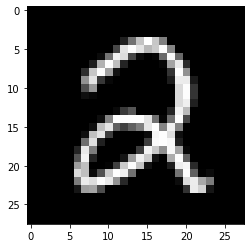

In [6]:
plt.figure()
plt.imshow(X[0], cmap=plt.cm.gray)
plt.show()

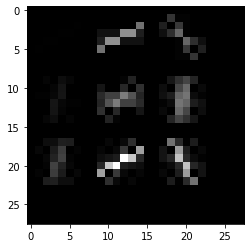

In [7]:
plt.figure()
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.show()

In [8]:
fd.shape

(72,)

In [9]:
X_hoc = np.empty((X.shape[0], fd.shape[0]), dtype=np.float32)

In [10]:
for i in range(X.shape[0]):
    x_hoc = hog(X[i],
                orientations=8,
                cells_per_block=(1, 1),
                visualize=False,
                multichannel=False)
    X_hoc[i] = x_hoc.squeeze()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_hoc, y, train_size=0.8)
print(X_train.shape)

(56000, 72)


In [12]:
model = SVC()
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [20]:
acc = model.score(X_test, y_test)
print('accuracy on test set: ', acc)

accuracy on test set:  0.9512142857142857


In [14]:
# Create ART wrapper
SklearnClassifier = art.estimators.classification.SklearnClassifier
X_min = X_hoc.min()
X_max = X_hoc.max()
print(X_min, X_max)
classifier = SklearnClassifier(model=model, clip_values=(X_min, X_max))
predictions = classifier.predict(X_test[:5])
print(predictions)

0.0 1.0
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [15]:
# Attack the SVM, generating 1000 adversarial examples
n = 100
FGSM = art.attacks.evasion.FastGradientMethod
attack = FGSM(estimator=classifier, eps=0.2)
adv = attack.generate(x=X_test[:n])
predictions = np.argmax(classifier.predict(adv), axis=1)
acc = np.sum(predictions == model.predict(X_test[:n])) / n
acc

0.06

In [16]:
print(adv[0])
print(X_test[0])

[0.3773399  0.3773399  0.3773399  0.2        0.20599759 0.2
 0.2        0.2        0.2        0.34480453 0.5157889  0.2
 0.7448045  0.34480453 0.2        0.         0.2        0.2
 0.2        0.2        0.5071068  0.5071068  0.2        0.2
 0.3        0.3        0.         0.2        0.2        0.2
 0.3        0.3        0.19889866 0.19889866 0.19889866 0.4127891
 0.59889865 0.59889865 0.2        0.19889866 0.27749878 0.2
 0.2        0.2        0.24167289 0.27749878 0.27749878 0.14772086
 0.2753033  0.         0.2        0.2        0.06521933 0.2843365
 0.2843365  0.2843365  0.22084449 0.2        0.2673208  0.34315193
 0.3035488  0.3035488  0.3035488  0.2        0.23096791 0.29875946
 0.38382292 0.38382292 0.4618808  0.2        0.2        0.2       ]
[0.5773399  0.5773399  0.5773399  0.         0.00599758 0.
 0.         0.         0.         0.5448045  0.3157889  0.
 0.5448045  0.5448045  0.         0.09920421 0.         0.
 0.         0.         0.70710677 0.70710677 0.         0.
 0.

In [17]:
# Compute L2 norm
l2 = np.linalg.norm(X_test[:n] - adv)
print(l2)

15.251106


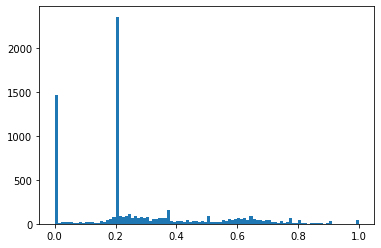

In [18]:
counts, bins = np.histogram(adv.flatten(), 100)
plt.figure()
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

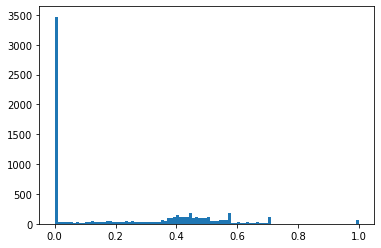

In [19]:
counts, bins = np.histogram(X_test[:n].flatten(), 100)
plt.figure()
plt.hist(bins[:-1], bins, weights=counts)
plt.show()